In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import itertools
import math
import pandas as pd
import os
import numpy as np

In [3]:
BATCHSIZE = 64
EPOCH = 10
LATENT_DIM = 100
LATENT_DIM_DECODER = LATENT_DIM
SAMPLES = 10000
MAX_WORD_NUM = SAMPLES
MAX_SEQ_LEN = 100
EMBEDDING = MAX_SEQ_LEN
VOCAB_SIZE = 20000
MAXLEN = 200
BATCHSIZE = 32

In [4]:
data_train = pd.read_csv('/content/drive/My Drive/datasets/classification_train.csv', na_values='NaN', names=['class', 'title', 'description'])
data_test = pd.read_csv('/content/drive/My Drive/datasets/classification_test.csv', na_values='NaN', names=['class', 'title', 'description'])

In [5]:
data_train

,class,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [6]:
data_test

,class,title,description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...
...,...,...,...
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...
7596,2,Void is filled with Clement,With the supply of attractive pitching options...
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...


In [7]:
x = []
y = []
for cl, title, desc in data_train[['class', 'title', 'description']].values:
  x.append(title + desc)
  y.append(cl-1)
for cl, title, desc in data_test[['class', 'title', 'description']].values:
  x.append(title + desc)
  y.append(cl-1)
x = x[:5000]
y = y[:5000]

In [8]:
vocab = set(itertools.chain.from_iterable(s for s in x)) 
tags = set(itertools.chain(s for s in y))
sentenecs_lens = list(map(len, x))

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [10]:
words_tokenizer = Tokenizer(num_words=MAX_WORD_NUM)
words_tokenizer.fit_on_texts(x)
word_index = words_tokenizer.word_index
max_in_len = max(len(s) for s in x)
print(f"Number of input tokens: {len(word_index)}")
print(f"Maximum input sequence length: {max_in_len}")

Number of input tokens: 19175
Maximum input sequence length: 958


In [11]:
words_seq = words_tokenizer.texts_to_sequences(x)

In [12]:
words_seq_pad = pad_sequences(words_seq, maxlen=max_in_len)

In [13]:
wordVec = {}
print('Loading wordVec')
with open('/content/drive/My Drive/datasets/glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        data = line.split()
        word = data[0]
        vec = np.asarray(data[1:], dtype='float32')
        wordVec[word] = vec
print('Finished loading wordVec.')

Loading wordVec
Finished loading wordVec.


In [14]:
wordNum = min(MAX_WORD_NUM, len(word_index) + 1)
word_embedding = np.zeros((wordNum, EMBEDDING))

for tok, idx in word_index.items():
    if idx < MAX_WORD_NUM:
        word_vector = wordVec.get(tok)
        if word_vector is not None:
            word_embedding[idx] = word_vector

In [15]:
man_target_one_hot = np.zeros((len(x), 1, 4), dtype='float32')

for idx, tok in enumerate(y):
  man_target_one_hot[idx, 0, tok] = 1

In [16]:
from keras.layers import Embedding, Input, LSTM, GRU, Dense, Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda, TimeDistributed
import keras.backend as K
from keras.models import Model

In [17]:
# Embedding
embedding = Embedding(wordNum, EMBEDDING, weights=[word_embedding], input_length=max_in_len)

# Encoder
input_layer_encoder = Input(shape=(max_in_len,))
embed_encoder = embedding(input_layer_encoder)
encoder = Bidirectional(LSTM(LATENT_DIM, return_sequences=True, dropout=0.2))
encoder_out = encoder(embed_encoder)

# Decoder input
input_layer_decoder = Input(shape=(1,))
embed_decoder = Embedding(4, EMBEDDING)
decoder_input = embed_decoder(input_layer_decoder)

# Decoder output, after attention
decoder = LSTM(LATENT_DIM_DECODER, return_state=True)
dense_decode = Dense(4, activation='softmax')
s0 = Input(shape=(LATENT_DIM_DECODER,))
c0 = Input(shape=(LATENT_DIM_DECODER,))

In [18]:
# Dimension of x is N x T x D.
def softmax(x):
    assert(K.ndim(x) > 2)
    e = K.exp(x - K.max(x, axis=1, keepdims=True))
    s = K.sum(e, axis=1, keepdims=True)
    return e / s

repeat_attn = RepeatVector(max_in_len)
concat_attn = Concatenate(axis=-1)
dense1_attn = Dense(10, activation='tanh')
# dense1_attn = Dense(5, activation='tanh') 
dense2_attn = Dense(1, activation=softmax)
dot_attn = Dot(axes=1)                      

def iterAttn(h, prevOut):
    prevOutRepeat = repeat_attn(prevOut)
    total = concat_attn([h, prevOutRepeat])
    d = dense1_attn(total)
    alphaLayer = dense2_attn(d)
    context = dot_attn([alphaLayer, h])
    
    return context

In [19]:
s = s0
c = c0

all_out = []
for t in range(1):
    context = iterAttn(encoder_out, s) 
    
    select_layer = Lambda(lambda x: x[:, t:t+1])
    prevWord = select_layer(decoder_input)
    
    concat2 = Concatenate(axis=2)
    decoder_in_concat = concat2([context, prevWord])
    
    pred, s, c = decoder(decoder_in_concat, initial_state=[s, c])
    pred = dense_decode(pred)
    all_out.append(pred)

In [20]:
def stack(outputs):
    outputs = K.stack(outputs)
    return K.permute_dimensions(outputs, pattern=(1, 0, 2))

stack_layer = Lambda(stack)
all_out = stack_layer(all_out)

In [21]:
attnModel = Model(inputs=[input_layer_encoder, input_layer_decoder, s0, c0,],
                 outputs=all_out)

In [22]:
def myLoss(y_train, pred):
    mask = K.cast(y_train > 0, dtype='float32')
    val = mask * y_train * K.log(pred)
    return -K.sum(val) / K.sum(mask)

def acc(y_train, pred):
    targ = K.argmax(y_train, axis=-1)
    pred = K.argmax(pred, axis=-1)
    correct = K.cast(K.equal(targ, pred), dtype='float32')

    mask = K.cast(K.greater(targ, 0), dtype='float32')
    correctCount = K.sum(mask * correct)
    totalCount = K.sum(mask)
    return correctCount / totalCount

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [23]:
attnModel.compile(optimizer='adam', loss=myLoss, metrics=[acc, recall_m, precision_m, f1_m])

init_s = np.zeros((len(words_seq_pad), LATENT_DIM_DECODER))
init_c = np.zeros((len(words_seq_pad), LATENT_DIM_DECODER))

history = attnModel.fit(
    x=[words_seq_pad, np.array(y), init_s, init_c],
    y=man_target_one_hot,
    batch_size=BATCHSIZE,
    epochs=EPOCH
)

Epoch 1/10
157/157 [==============================] - 237s 1s/step - loss: 0.6408 - acc: 0.7759 - recall_m: 0.5505 - precision_m: 0.6367 - f1_m: 0.5716
Epoch 2/10
157/157 [==============================] - 232s 1s/step - loss: 0.0019 - acc: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - f1_m: 1.0000
Epoch 3/10
157/157 [==============================] - 232s 1s/step - loss: 7.1352e-04 - acc: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - f1_m: 1.0000
Epoch 4/10
157/157 [==============================] - 232s 1s/step - loss: 3.8908e-04 - acc: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - f1_m: 1.0000
Epoch 5/10
157/157 [==============================] - 231s 1s/step - loss: 2.4184e-04 - acc: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - f1_m: 1.0000
Epoch 6/10
157/157 [==============================] - 231s 1s/step - loss: 1.6619e-04 - acc: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - f1_m: 1.0000
Epoch 7/10
157/157 [==============================] - 232s 1s/step - los

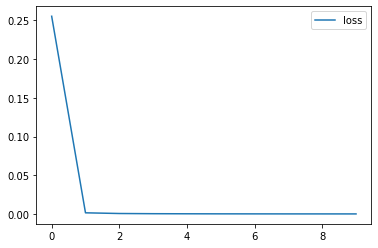

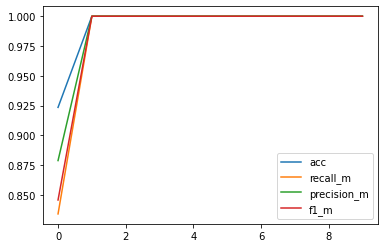

In [24]:
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['recall_m'], label='recall_m')
plt.plot(history.history['precision_m'], label='precision_m')
plt.plot(history.history['f1_m'], label='f1_m')
plt.legend()
plt.show()